In [3]:
import cv2 
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import pandas as pd
from scipy.io import loadmat

### Show Sample Ground Truth Edge

In [ ]:
DATASET_PATH = "YourPath"

In [ ]:
edge_map_test_image_path = DATASET_PATH + "/BIPEDv2/BIPED/edges/edge_maps/test/rgbr/real"
real_image_test_path = DATASET_PATH + "/BIPEDv2/BIPED/edges/imgs/test/rgbr/real"

edge_map_test_image_path = Path(edge_map_test_image_path)
edge_map_test_image_list = list(edge_map_test_image_path.glob("*.png"))

real_image_test_path = Path(real_image_test_path)
real_image_test_list = list(real_image_test_path.glob("*.jpg"))


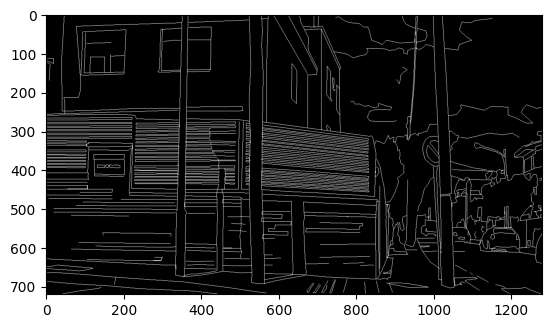

In [3]:
p = DATASET_PATH + "/BIPEDv2/BIPED/edges/edge_maps/test/rgbr/RGB_029.png"

im  = cv2.imread(p)
im = cv2.cvtColor(im,cv2.COLOR_BGR2GRAY)
plt.imshow(im,cmap="gray");

### Main Edge Detector

#### Show Edge Detector Result

In [4]:
def edge_detector(gray_image):
    edge_map = np.zeros(gray_image.shape)
    for i in range(1,gray_image.shape[0]-1):
        for j in range(1,gray_image.shape[1]-1):
            a = gray_image[i-1:i+2,j-1:j+2].flatten()
            Ab=a[1] + a[2]+ a[5]+ a[8] 
            Ap=a[0] + a[3]+ a[6]+ a[7] 
            Bb=a[0]+ a[1]+ a[2]+ a[3]
            Bp=a[5]+ a[6]+ a[7]+ a[8] 
            Cp=a[2]+ a[5]+ a[7]+ a[8]
            Cb=a[0] + a[1]+ a[3]+ a[6] 
            Db=a[0]+ a[1]+ a[2]+ a[5]
            Dp=a[3] + a[6]+ a[7]+ a[8]
            edge_map[i,j]= ( (Cp * Bp) + (Bb * Cb)) - ( (Dp*Ab) + (Db*Ap) ) 
    
    return edge_map

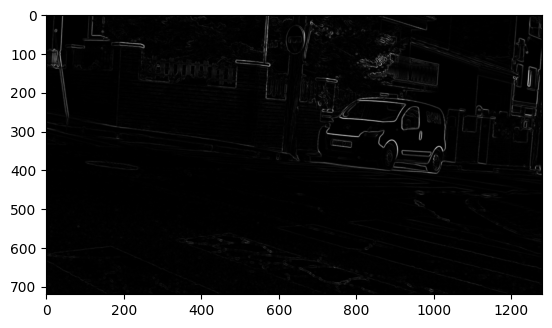

In [8]:
sample_image = cv2.imread(DATASET_PATH + "/BIPED/edges/imgs/test/rgbr/RGB_010.jpg")

sample_image = cv2.cvtColor(sample_image,cv2.COLOR_BGR2GRAY)

sample_image = cv2.GaussianBlur(sample_image,(3,3),0)

sample_image =  sample_image / 255.

plt.imshow(edge_detector(sample_image),cmap="gray")

In [3]:
def edge_detector(gray_image):
    """Main Algorithm 

    Args:
        gray_image (_type_): _description_

    Returns:
        _type_: binary(0,1) edge image
    """

    edge_map = np.zeros(gray_image.shape)

    gray_image =  gray_image / 255.

    gray_image = cv2.GaussianBlur(gray_image,(3,3),0)

    gray_image = np.array(gray_image)

    height = gray_image.shape[0]-1
    width = gray_image.shape[1]-1

    for i in range(1,height):

        for j in range(1,width):

            a = gray_image[i-1:i+2,j-1:j+2].flatten()

            Ab=a[1] + a[2]+ a[5]+ a[8] 
            Ap=a[0] + a[3]+ a[6]+ a[7] 
            Bb=a[0]+ a[1]+ a[2]+ a[3]
            Bp=a[5]+ a[6]+ a[7]+ a[8] 
            Cp=a[2]+ a[5]+ a[7]+ a[8]
            Cb=a[0] + a[1]+ a[3]+ a[6] 
            Db=a[0]+ a[1]+ a[2]+ a[5]
            Dp=a[3] + a[6]+ a[7]+ a[8]

            edge_map[i,j]= ( (Cp * Bp) + (Bb * Cb)) - ( (Dp*Ab) + (Db*Ap) )
    
    edge_map = edge_map * 255

    edge_map = edge_map.astype(np.uint8)

    _, final_binary = cv2.threshold(
    edge_map, 0,1 , cv2.THRESH_BINARY + cv2.THRESH_OTSU,)
    
    return final_binary

### Calculate Metrics

In [4]:

def calculate_metrics(detected_edges, ground_truth_edges):
    """for one2one image compare

    Args:
        detected_edges (_type_): _description_
        ground_truth_edges (_type_): binary image (0,1)

    Returns: accuracy, precision, recall , f1_score
        
    """
    # Ensure the images are of the same size
    assert detected_edges.shape == ground_truth_edges.shape, "Image sizes do not match"
    
    true_positives = np.sum((detected_edges == 1) & (ground_truth_edges == 1))
    true_negatives = np.sum((detected_edges == 0) & (ground_truth_edges == 0))
    false_positives = np.sum((detected_edges == 1) & (ground_truth_edges == 0))
    false_negatives = np.sum((detected_edges == 0) & (ground_truth_edges == 1))
    
    total_pixels = detected_edges.size
    
    accuracy = (true_positives + true_negatives) / total_pixels 
    precision = true_positives / (true_positives + false_positives)
    recall = true_positives / (true_positives + false_negatives)
    f1_score = (2 * (precision * recall)) / (precision + recall)
    
    return accuracy, precision, recall , f1_score



### Useful Functions

In [5]:
def apply_canny_on_dataset(dataset:list, tresh1:int , tresh2:int):
    """_summary_

    Args:
        dataset (list): list of real images 
        tresh1 (int): treshold1 of canny
        tresh2 (int): treshold2 of canny

    Returns:
        _type_: _description_
    """
    
    dataset_edge_maps = []
    for image_path in dataset:

        image = cv2.imread(str(image_path))
        image =  cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        dataset_edge_maps.append(cv2.Canny(image=image,threshold1=tresh1,threshold2=tresh2) / 255.)

    return dataset_edge_maps


In [57]:
def apply_sobel_on_dataset(dataset:list):

    dataset_edge_maps = []
    for image_path in dataset:
        
        image = cv2.imread(str(image_path))
        image =  cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        image =  image / 255.
        sobelx = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=5)
        sobely = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=5)

        _ , final_sobel = cv2.threshold(cv2.magnitude(sobelx, sobely)
                                    ,7,255,cv2.THRESH_BINARY)

        final_sobel =  final_sobel / 255. # for binary

        dataset_edge_maps.append(final_sobel)

    return dataset_edge_maps



In [7]:
def apply_dir_on_dataset(dataset:list):
    """dir : Differences in Intensities of Rotating Kernel Borders

    Args:
        dataset (list): path of real RGB images

    Returns:
        _type_: _description_
    """
    dataset_edge_maps = []
    for image_path in dataset:
        image =  cv2.imread((str(image_path)))

        image = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)

        dataset_edge_maps.append(
            edge_detector(image)
            )
    
    return dataset_edge_maps

In [8]:
def comparison(predicts:list,ground_truth_edges_path:list):
    """comparison of a results of an algorithm with ground_truth_edges

    Args:
        predict (list): list of predict edge arrays
        ground_truth_edges (list): list of ground_truth_edges path (RBG)
    """
    accuracies, precisions, recalls , f1_scores = [], [] , [], []
    for i in range(len(predicts)):
        
        #change image to binary format (0,1)
        ground_truth_edge = cv2.imread(str(ground_truth_edges_path[i]),cv2.IMREAD_GRAYSCALE)
        # Convert edges to binary format 
        ground_truth_edge = ground_truth_edge / 255.
        
        accuracy, precision, recall , f1_score = calculate_metrics(predicts[i],ground_truth_edge)
        accuracies.append(accuracy)
        precisions.append(precision)
        recalls.append(recall)
        f1_scores.append(f1_score)
    
    return np.mean(accuracies),np.mean(precisions), np.mean(recalls), np.mean(f1_scores)


## Tests on BIPED

https://www.kaggle.com/datasets/xavysp/biped

### Canny

In [113]:
canny_edges =  apply_canny_on_dataset(real_image_test_list,100,250)

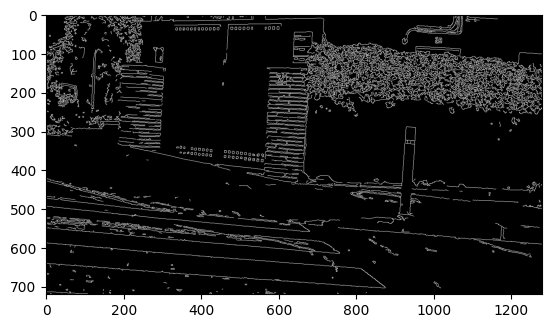

In [ ]:
plt.imshow(canny_edges[0],cmap="gray");

In [ ]:
np.unique(canny_edges[0])

array([0., 1.])

----

### Sobel

In [ ]:
sobel_edges = apply_sobel_on_dataset(real_image_test_list)

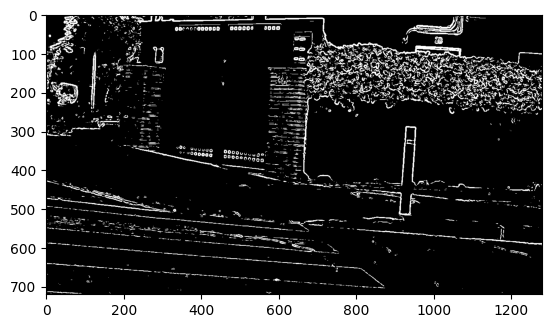

In [ ]:
plt.imshow(sobel_edges[0],cmap="gray");

In [ ]:
np.unique(sobel_edges[0])

array([0., 1.])

---

### Proposed

In [ ]:
dir_edges = apply_dir_on_dataset(real_image_test_list)

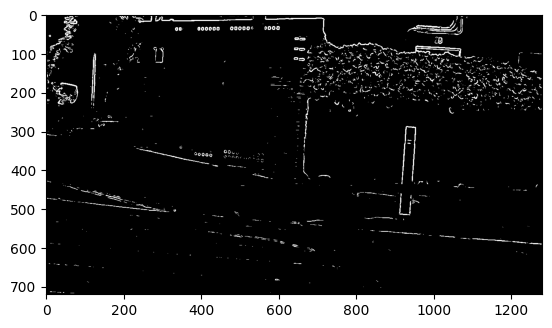

In [ ]:
plt.imshow(dir_edges[0],cmap="gray");

In [ ]:
np.unique(dir_edges[0])

array([0, 1], dtype=uint8)

---

### Canny Results

In [ ]:
accuracies_canny, precisions_canny, recalls_canny , f1_scores_canny = comparison(canny_edges,edge_map_test_image_list)

In [ ]:
accuracies_canny, precisions_canny, recalls_canny , f1_scores_canny

(0.9381991319444445,
 0.20081522777327415,
 0.22097689169984883,
 0.20451402437165503)

---

### Proposed Results

In [ ]:
accuracies_dir, precisions_dir, recalls_dir , f1_scores_dir = comparison(dir_edges,edge_map_test_image_list)

In [ ]:
accuracies_dir, precisions_dir, recalls_dir , f1_scores_dir

(0.9480725043402777,
 0.24900595342124504,
 0.2101234674687564,
 0.22092403117289547)

---

### Sobel Results

In [ ]:
accuracies_sobel, precisions_sobel, recalls_sobel , f1_scores_sobel = comparison(sobel_edges,edge_map_test_image_list)

In [ ]:
accuracies_sobel, precisions_sobel, recalls_sobel , f1_scores_sobel 

(0.9144284288194445,
 0.1943370608491992,
 0.4235601669322779,
 0.2620095766705153)

### Collect Results

In [ ]:
Canny = {
    "Name" : ["Canny"],
    "accuracy":accuracies_canny,
    "precision":precisions_canny,
    "recall" : recalls_canny,
    "f1_score": f1_scores_canny
}

Sobel = {
    "Name" : ["Sobel"],
    "accuracy":accuracies_sobel,
    "precision":precisions_sobel,
    "recall" : recalls_sobel,
    "f1_score": f1_scores_sobel
}

Proposed = {
    "Name" : ["Proposed"],
    "accuracy":accuracies_dir,
    "precision":precisions_dir,
    "recall" : recalls_dir,
    "f1_score": f1_scores_dir
}

df1 = pd.DataFrame(Canny)
df2 = pd.DataFrame(Sobel)
df3 = pd.DataFrame(Proposed)


result_df = pd.concat([df1, df2, df3], ignore_index=True)


result_df


,Name,accuracy,precision,recall,f1_score
0,Canny,0.930946,0.183966,0.246752,0.204733
1,Sobel,0.914428,0.194337,0.423560,0.262010
2,Proposed,0.948073,0.249006,0.210123,0.220924


# Tests on BSDS500

https://www.kaggle.com/datasets/balraj98/berkeley-segmentation-dataset-500-bsds500

In [9]:
im = loadmat("/media/alireza/2ADF0001DEFFC2DD/AI/Vision/archive/ground_truth/test/344010.mat")['groundTruth'][0][0][0][0][1]

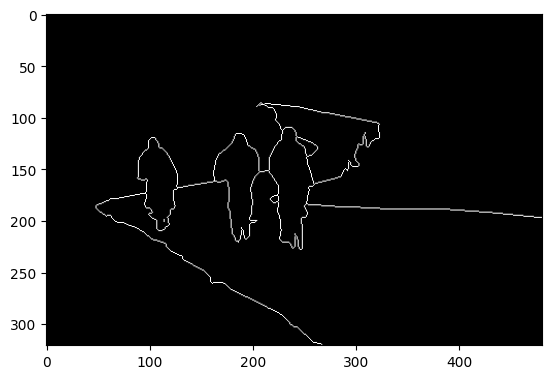

In [23]:
plt.imshow(im,cmap="gray");

In [28]:
real_image_train_path = "/archive/images/train"
edge_image_train_path = "/archive/ground_truth/train"

edge_map_train_image_path = Path(edge_image_train_path)
edge_map_train_image_list_bsds = list(edge_map_train_image_path.glob("*.mat"))

real_image_train_path = Path(real_image_train_path)
real_image_train_list_bsds = list(real_image_train_path.glob("*.jpg"))

In [11]:
len(real_image_train_list_bsds)

200

In [12]:
len(edge_map_train_image_list_bsds)

200

In [13]:
def comparison_v2(predicts:list,ground_truth_edges_path:list):
    """comparison of a results of an algorithm with ground_truth_edges

    Args:
        predict (list): list of predict edge arrays
        ground_truth_edges (list): list of ground_truth_edges path (RBG)
    """
    accuracies, precisions, recalls , f1_scores = [], [] , [], []
    for i in range(len(predicts)):
        
        #ground truth edge is binary
        ground_truth_edge = loadmat(str(ground_truth_edges_path[i]))['groundTruth'][0][0][0][0][1]
        
        
        accuracy, precision, recall , f1_score = calculate_metrics(predicts[i],ground_truth_edge)
        accuracies.append(accuracy)
        precisions.append(precision)
        recalls.append(recall)
        f1_scores.append(f1_score)
    
    return np.mean(accuracies),np.mean(precisions), np.mean(recalls), np.mean(f1_scores)


## Canny

In [53]:
canny_edges_bsds = apply_canny_on_dataset(real_image_train_list_bsds,200,300)

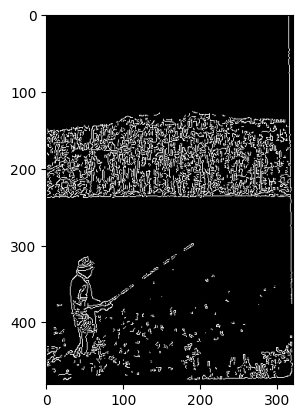

In [54]:
plt.imshow(canny_edges_bsds[0],cmap="gray");

In [55]:
accuracies_canny_bsds, precisions_canny_bsds, recalls_canny_bsds , f1_scores_canny_bsds = comparison_v2(canny_edges_bsds,edge_map_train_image_list_bsds)

In [56]:
accuracies_canny_bsds, precisions_canny_bsds, recalls_canny_bsds , f1_scores_canny_bsds

(0.9217354486046073,
 0.06552777368106327,
 0.19789573940711144,
 0.08750927382443187)

---

## Sobel

In [29]:
sobel_edge_bsds = apply_sobel_on_dataset(real_image_train_list_bsds)

In [30]:
accuracies_sobel_bsds, precisions_sobel_bsds, recalls_sobel_bsds , f1_scores_sobel_bsds = comparison_v2(sobel_edge_bsds,edge_map_train_image_list_bsds)

In [31]:
accuracies_sobel_bsds, precisions_sobel_bsds, recalls_sobel_bsds , f1_scores_sobel_bsds

(0.8578481680818129,
 0.06733055223324896,
 0.44206352422195494,
 0.10948404611312341)

---

## Proposed

In [32]:
dir_edges_bsds = apply_dir_on_dataset(real_image_train_list_bsds)

In [59]:
accuracies_dir_bsds, precisions_dir_bsds, recalls_dir_bsds , f1_scores_dir_bsds = comparison_v2(dir_edges_bsds,edge_map_train_image_list_bsds)

In [60]:
accuracies_dir_bsds, precisions_dir_bsds, recalls_dir_bsds , f1_scores_dir_bsds

(0.9472225892319349,
 0.09496875922464834,
 0.1920733748180686,
 0.1149743960644334)

## Collect Results

In [63]:
Canny = {
    "Name" : ["Canny"],
    "accuracy":accuracies_canny_bsds,
    "precision":precisions_canny_bsds,
    "recall" : recalls_canny_bsds,
    "f1_score": f1_scores_canny_bsds
}

Sobel = {
    "Name" : ["Sobel"],
    "accuracy":accuracies_sobel_bsds,
    "precision":precisions_sobel_bsds,
    "recall" : recalls_sobel_bsds,
    "f1_score": f1_scores_sobel_bsds
}

Proposed = {
    "Name" : ["Proposed"],
    "accuracy":accuracies_dir_bsds,
    "precision":precisions_dir_bsds,
    "recall" : recalls_dir_bsds,
    "f1_score": f1_scores_dir_bsds
}

df1 = pd.DataFrame(Canny)
df2 = pd.DataFrame(Sobel)
df3 = pd.DataFrame(Proposed)


result_df = pd.concat([df1, df2, df3], ignore_index=True)


result_df

,Name,accuracy,precision,recall,f1_score
0,Canny,0.921735,0.065528,0.197896,0.087509
1,Sobel,0.857848,0.067331,0.442064,0.109484
2,Proposed,0.947223,0.094969,0.192073,0.114974
